In [1]:
%pip install gdown
%pip install tqdm
import gdown

url = "https://drive.google.com/drive/folders/1iYO-Kwh4RFq6mm5UNPTRO7te8T6jOA6f?usp=drive_link"
gdown.download_folder(url, quiet=True)

['/content/Dataset/AlexNet.py',
 '/content/Dataset/custom_cnn.py',
 '/content/Dataset/Dataset_resized.zip']

In [2]:
import os
import zipfile
import shutil
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch


# Percorso della cartella Project_Biometric/Dataset
dataset_path = "Dataset"

# Funzione per estrarre i file zip e rimuoverli
def extract_and_remove_zip(zip_path, extract_to):
    """
    Estrae il contenuto di un file zip e poi elimina il file zip.
    Args:
        zip_path (str): percorso del file zip da estrarre.
        extract_to (str): cartella di destinazione in cui estrarre i file.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    os.remove(zip_path)  # Rimuove il file zip dopo l'estrazione
    print(f"File zip {zip_path} estratto e rimosso.")

# Estrai e rimuovi i file ZIP nella cartella dataset
zip_files = [f for f in os.listdir(dataset_path) if f.endswith('.zip')]
for zip_file in zip_files:
    zip_path = os.path.join(dataset_path, zip_file)
    extract_and_remove_zip(zip_path, dataset_path)

# Funzione per analizzare il nome del file
# def parse_filename(filename):
#     parts = filename.split("_")
#     object_type = parts[0]  # Nome oggetto (es. nose, mouth, eyes)
#     age = parts[1]          # Età
#     gender = parts[2]       # Sesso
#     ethnicity = parts[3]    # Etnia
#     return object_type, age, gender, ethnicity

# dataset_path = "Dataset/Dataset_resized"

# # Processa ogni sottocartella (ad esempio eyes, mouth, nose)
# for folder in os.listdir(dataset_path):
#     folder_path = os.path.join(dataset_path, folder)

#     # Procedi solo se è una directory
#     if os.path.isdir(folder_path):
#         print(f"Elaborazione della cartella: {folder}")

#         # Crea le sottocartelle train e test
#         train_folder = os.path.join(folder_path, "train")
#         test_folder = os.path.join(folder_path, "test")
#         os.makedirs(train_folder, exist_ok=True)
#         os.makedirs(test_folder, exist_ok=True)

#         # Raggruppa i file in base a età ed etnia
#         file_groups = defaultdict(list)
#         files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]

#         # Raggruppa per età ed etnia
#         for file in files:
#             file_path = os.path.join(folder_path, file)
#             try:
#                 object_type, age, gender, ethnicity = parse_filename(file)
#                 if object_type and age and gender and ethnicity:
#                     file_groups[(age, ethnicity)].append(file)
#                 else:
#                     print(f"File non valido (parametri mancanti): {file}. Eliminazione...")
#                     os.remove(file_path)  # Elimina file non valido
#             except IndexError:
#                 print(f"File non conforme al formato: {file}. Eliminazione...")
#                 os.remove(file_path)  # Elimina file non conforme

#         # Suddividi i file in modo bilanciato tra train e test
#         train_files = []
#         test_files = []

#         for group, group_files in file_groups.items():
#             if len(group_files) == 1:
#                 # Se c'è solo un file, assegnalo al training set
#                 train_files.extend(group_files)
#             else:
#                 # Altrimenti, suddividi il gruppo in train e test (80% train, 20% test)
#                 train, test = train_test_split(group_files, test_size=0.2, random_state=42)
#                 train_files.extend(train)
#                 test_files.extend(test)

#         # Sposta i file nelle rispettive cartelle train e test
#         for file in train_files:
#             shutil.move(os.path.join(folder_path, file), os.path.join(train_folder, file))

#         for file in test_files:
#             shutil.move(os.path.join(folder_path, file), os.path.join(test_folder, file))

# # Comprime l'intera directory in un file zip
# zip_path = f"{dataset_path}.zip"
# print(f"Compressione della cartella principale in: {zip_path}")
# shutil.make_archive(dataset_path, 'zip', dataset_path)

print("Processo completato!")




File zip Dataset/Dataset_resized.zip estratto e rimosso.
Processo completato!


**Conteggio numero immagini per ogni set**

In [3]:
dataset_path = "Dataset"
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)

    # Procedi solo se è una directory
    if os.path.isdir(folder_path):
        train_folder = os.path.join(folder_path, "train")
        test_folder = os.path.join(folder_path, "test")

        train_count = len([f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]) if os.path.exists(train_folder) else 0
        test_count = len([f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]) if os.path.exists(test_folder) else 0

        print(f"Cartella '{folder}':")
        print(f"  Train set: {train_count} file")
        print(f"  Test set: {test_count} file")

Cartella 'mouth':
  Train set: 18255 file
  Test set: 4776 file
Cartella 'nose':
  Train set: 18255 file
  Test set: 4776 file
Cartella 'eyes':
  Train set: 18255 file
  Test set: 4776 file
Cartella '__pycache__':
  Train set: 0 file
  Test set: 0 file


In [4]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
# Impostare la trasformazione
transform_eyes = transforms.Compose([
    transforms.Resize((44, 266)),  # Cambia dimensione a (altezza, larghezza)
    transforms.ToTensor(),        # Converte l'immagine in tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizzazione
])

# Transform per il naso (108x170)
transform_nose = transforms.Compose([
    transforms.Resize((170, 108)),  # Cambia dimensione a (altezza, larghezza)
    transforms.ToTensor(),         # Converte l'immagine in tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizzazione
])

# Transform per la bocca (193x89)
transform_mouth = transforms.Compose([
    transforms.Resize((89, 193)),  # Cambia dimensione a (altezza, larghezza)
    transforms.ToTensor(),        # Converte l'immagine in tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizzazione
])

# Dataset personalizzato
class EthnicityDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Scansione della cartella per ottenere i file
        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Considerando immagini .jpg e .png
                self.images.append(filename)

                # Estraiamo l'etnia dalla parte finale del nome del file
                # esempio: eyes_100_1_0_20170112213001988
                parts = filename.split('_')
                if len(parts) >= 4:
                    label = parts[3]  # L'etnia è il quarto elemento (indice 3)
                    label_map = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4}  # Mappatura delle etnie
                    self.labels.append(label_map.get(label, -1))  # -1 se l'etnia non è trovata

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.root_dir, image_name)

        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Errore nel caricamento dell'immagine {image_path}: {e}")
            return None, None

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        # Aggiungi un controllo se l'etichetta è corretta
        if label == -1:
            print(f"Errore: etichetta non trovata per {image_name}")

        return image, label

In [6]:
from Dataset.custom_cnn import CNN
from Dataset.AlexNet import AlexNet
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import seaborn as sns
import matplotlib.pyplot as plt
import math

def get_output_size(x, y):
    # Layer 1 (Conv2d + MaxPool2d)
    x1 = math.floor((x - 11) / 4) + 1  # Dopo Conv2d
    x1 = math.floor(x1 / 2)  # Dopo MaxPool2d
    y1 = math.floor((y - 11) / 4) + 1  # Dopo Conv2d
    y1 = math.floor(y1 / 2)  # Dopo MaxPool2d

    # Layer 2 (Conv2d + MaxPool2d)
    x2 = math.floor((x1 - 5 + 2 * 2) / 1) + 1  # Dopo Conv2d (kernel 5, stride 1, padding 2)
    x2 = math.floor(x2 / 2)  # Dopo MaxPool2d
    y2 = math.floor((y1 - 5 + 2 * 2) / 1) + 1  # Dopo Conv2d
    y2 = math.floor(y2 / 2)  # Dopo MaxPool2d

    # Layer 3 (Conv2d, senza pooling)
    x3 = x2  # La dimensione non cambia
    y3 = y2  # La dimensione non cambia

    # Layer 4 (Conv2d, senza pooling)
    x4 = x3  # La dimensione non cambia
    y4 = y3  # La dimensione non cambia

    # Layer 5 (Conv2d, senza MaxPool2d)
    x_out = x4
    y_out = y4

    return x_out, y_out

ex = 266
ey = 44
nx = 108
ny = 170
my = 89
mx = 193

ex, ey = get_output_size(ex, ey)
nx, ny = get_output_size(nx, ny)
mx, my = get_output_size(mx, my)

e_x = 16
e_y = 2
n_x = 6
n_y = 10
m_x = 12
m_y = 5

hid_1 = 64
hid_2 = 64
hid_3 = 128
hid_4 = 128
hid_5 = 128
hid_6 = 128
drop_1 = 0.2
drop_2 = 0.5

eyes_net = CNN(hid_1, hid_2, hid_3, hid_4, hid_5, hid_6, e_x, e_y, drop_1, drop_2)
nose_net = CNN(hid_1, hid_2, hid_3, hid_4, hid_5, hid_6, n_x, n_y, drop_1, drop_2)
mouth_net = CNN(hid_1, hid_2, hid_3, hid_4, hid_5, hid_6, m_x, m_y, drop_1, drop_2)

# eyes_net = AlexNet(ex,ey)
# nose_net = AlexNet(nx,ny)
# mouth_net = AlexNet(mx,my)

class_names = ["White", "Black", "Asian", "Indian", "Others"]

**EYES TRAINING VALIDATION AND TEST**

In [7]:
# Inizializzare il dataset
full_train_dataset = EthnicityDataset(root_dir="Dataset/eyes/train", transform=transform_eyes)
test_dataset = EthnicityDataset(root_dir="Dataset/eyes/test", transform=transform_eyes)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Parametri di Early Stopping
patience = 4  # Numero massimo di epoche senza miglioramenti

# K-fold Cross-Validation
k = 5  # Scegliamo K = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Array per salvare i risultati di ogni fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []

num_epochs = 10
batch_size = 32

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_train_dataset)))):
    print(f"Fold {fold + 1}/{k}")

    # Creare i subset per training e validation
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Creare i dataloader per il fold corrente
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Reinizializzare il modello e l'ottimizzatore per ogni fold
    eyes_net = eyes_net.to(device)  # Assicurarsi che il modello sia su GPU/CPU corretta
    eyes_optimizer = torch.optim.Adam(eyes_net.parameters(), lr=0.001, weight_decay=0.0001)

    # Criterion
    criterion = nn.CrossEntropyLoss()

    best_model_state = None  # Per salvare lo stato del modello
    best_val_loss = float("inf")  # Migliore loss iniziale
    no_improvement = 0  # Contatore per epoche senza miglioramenti

    # Metriche per ogni fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training per ogni fold
    for epoch in range(num_epochs):
        # Training Phase
        eyes_net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Training Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            eyes_optimizer.zero_grad()

            # Forward pass
            outputs = eyes_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            eyes_optimizer.step()

            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        eyes_net.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = eyes_net(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early Stopping: verifica miglioramento della loss di validazione
        if avg_val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
            best_val_loss = avg_val_loss
            best_model_state = eyes_net.state_dict()  # Salva il miglior modello
            no_improvement = 0  # Resetta il contatore
        else:
            no_improvement += 1
            print(f"No improvement for {no_improvement} epochs.")

        # Controlla se interrompere l'allenamento per Early Stopping
        if no_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

    # Carica il miglior modello salvato per questo fold
    eyes_net.load_state_dict(best_model_state)

    # Salvare i risultati del fold corrente
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

# Calcolare le metriche medie su tutti i fold
mean_train_loss = np.mean([np.mean(fold) for fold in fold_train_losses])
mean_val_loss = np.mean([np.mean(fold) for fold in fold_val_losses])
mean_train_accuracy = np.mean([np.mean(fold) for fold in fold_train_accuracies])
mean_val_accuracy = np.mean([np.mean(fold) for fold in fold_val_accuracies])

print(f"Average Training Loss: {mean_train_loss:.4f}")
print(f"Average Validation Loss: {mean_val_loss:.4f}")
print(f"Average Training Accuracy: {mean_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {mean_val_accuracy:.4f}")

Fold 1/5


Training Fold 1, Epoch 1: 100%|██████████| 457/457 [00:35<00:00, 12.76batch/s]


Fold 1, Epoch 1, Train Loss: 1.1721, Train Accuracy: 0.5620


Validating Fold 1, Epoch 1: 100%|██████████| 115/115 [00:03<00:00, 31.99batch/s]


Fold 1, Epoch 1, Val Loss: 1.0862, Val Accuracy: 0.5974
Validation loss improved from inf to 1.0862. Saving model...


Training Fold 1, Epoch 2: 100%|██████████| 457/457 [00:23<00:00, 19.71batch/s]


Fold 1, Epoch 2, Train Loss: 0.9714, Train Accuracy: 0.6389


Validating Fold 1, Epoch 2: 100%|██████████| 115/115 [00:03<00:00, 32.97batch/s]


Fold 1, Epoch 2, Val Loss: 1.0580, Val Accuracy: 0.6193
Validation loss improved from 1.0862 to 1.0580. Saving model...


Training Fold 1, Epoch 3: 100%|██████████| 457/457 [00:23<00:00, 19.66batch/s]


Fold 1, Epoch 3, Train Loss: 0.9067, Train Accuracy: 0.6672


Validating Fold 1, Epoch 3: 100%|██████████| 115/115 [00:03<00:00, 32.25batch/s]


Fold 1, Epoch 3, Val Loss: 0.9209, Val Accuracy: 0.6730
Validation loss improved from 1.0580 to 0.9209. Saving model...


Training Fold 1, Epoch 4: 100%|██████████| 457/457 [00:24<00:00, 18.88batch/s]


Fold 1, Epoch 4, Train Loss: 0.8536, Train Accuracy: 0.6902


Validating Fold 1, Epoch 4: 100%|██████████| 115/115 [00:03<00:00, 28.86batch/s]


Fold 1, Epoch 4, Val Loss: 0.8317, Val Accuracy: 0.7094
Validation loss improved from 0.9209 to 0.8317. Saving model...


Training Fold 1, Epoch 5: 100%|██████████| 457/457 [00:23<00:00, 19.77batch/s]


Fold 1, Epoch 5, Train Loss: 0.8105, Train Accuracy: 0.7041


Validating Fold 1, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 27.22batch/s]


Fold 1, Epoch 5, Val Loss: 0.9218, Val Accuracy: 0.6820
No improvement for 1 epochs.


Training Fold 1, Epoch 6: 100%|██████████| 457/457 [00:23<00:00, 19.81batch/s]


Fold 1, Epoch 6, Train Loss: 0.7691, Train Accuracy: 0.7187


Validating Fold 1, Epoch 6: 100%|██████████| 115/115 [00:04<00:00, 27.63batch/s]


Fold 1, Epoch 6, Val Loss: 0.8501, Val Accuracy: 0.7020
No improvement for 2 epochs.


Training Fold 1, Epoch 7: 100%|██████████| 457/457 [00:23<00:00, 19.69batch/s]


Fold 1, Epoch 7, Train Loss: 0.7318, Train Accuracy: 0.7392


Validating Fold 1, Epoch 7: 100%|██████████| 115/115 [00:03<00:00, 30.75batch/s]


Fold 1, Epoch 7, Val Loss: 0.7792, Val Accuracy: 0.7256
Validation loss improved from 0.8317 to 0.7792. Saving model...


Training Fold 1, Epoch 8: 100%|██████████| 457/457 [00:23<00:00, 19.63batch/s]


Fold 1, Epoch 8, Train Loss: 0.7008, Train Accuracy: 0.7469


Validating Fold 1, Epoch 8: 100%|██████████| 115/115 [00:03<00:00, 32.79batch/s]


Fold 1, Epoch 8, Val Loss: 0.7855, Val Accuracy: 0.7275
No improvement for 1 epochs.


Training Fold 1, Epoch 9: 100%|██████████| 457/457 [00:23<00:00, 19.64batch/s]


Fold 1, Epoch 9, Train Loss: 0.6632, Train Accuracy: 0.7605


Validating Fold 1, Epoch 9: 100%|██████████| 115/115 [00:03<00:00, 32.23batch/s]


Fold 1, Epoch 9, Val Loss: 0.8369, Val Accuracy: 0.6984
No improvement for 2 epochs.


Training Fold 1, Epoch 10: 100%|██████████| 457/457 [00:23<00:00, 19.62batch/s]


Fold 1, Epoch 10, Train Loss: 0.6269, Train Accuracy: 0.7742


Validating Fold 1, Epoch 10: 100%|██████████| 115/115 [00:03<00:00, 32.29batch/s]


Fold 1, Epoch 10, Val Loss: 0.7614, Val Accuracy: 0.7387
Validation loss improved from 0.7792 to 0.7614. Saving model...
Fold 2/5


Training Fold 2, Epoch 1: 100%|██████████| 457/457 [00:23<00:00, 19.57batch/s]


Fold 2, Epoch 1, Train Loss: 0.6623, Train Accuracy: 0.7640


Validating Fold 2, Epoch 1: 100%|██████████| 115/115 [00:03<00:00, 32.11batch/s]


Fold 2, Epoch 1, Val Loss: 0.6098, Val Accuracy: 0.7773
Validation loss improved from inf to 0.6098. Saving model...


Training Fold 2, Epoch 2: 100%|██████████| 457/457 [00:23<00:00, 19.66batch/s]


Fold 2, Epoch 2, Train Loss: 0.5969, Train Accuracy: 0.7873


Validating Fold 2, Epoch 2: 100%|██████████| 115/115 [00:03<00:00, 32.49batch/s]


Fold 2, Epoch 2, Val Loss: 0.5741, Val Accuracy: 0.7927
Validation loss improved from 0.6098 to 0.5741. Saving model...


Training Fold 2, Epoch 3: 100%|██████████| 457/457 [00:23<00:00, 19.67batch/s]


Fold 2, Epoch 3, Train Loss: 0.5574, Train Accuracy: 0.8010


Validating Fold 2, Epoch 3: 100%|██████████| 115/115 [00:03<00:00, 32.43batch/s]


Fold 2, Epoch 3, Val Loss: 0.6209, Val Accuracy: 0.7735
No improvement for 1 epochs.


Training Fold 2, Epoch 4: 100%|██████████| 457/457 [00:23<00:00, 19.70batch/s]


Fold 2, Epoch 4, Train Loss: 0.5086, Train Accuracy: 0.8153


Validating Fold 2, Epoch 4: 100%|██████████| 115/115 [00:03<00:00, 30.64batch/s]


Fold 2, Epoch 4, Val Loss: 0.6103, Val Accuracy: 0.7828
No improvement for 2 epochs.


Training Fold 2, Epoch 5: 100%|██████████| 457/457 [00:23<00:00, 19.79batch/s]


Fold 2, Epoch 5, Train Loss: 0.4647, Train Accuracy: 0.8331


Validating Fold 2, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 27.37batch/s]


Fold 2, Epoch 5, Val Loss: 0.6576, Val Accuracy: 0.7612
No improvement for 3 epochs.


Training Fold 2, Epoch 6: 100%|██████████| 457/457 [00:22<00:00, 19.94batch/s]


Fold 2, Epoch 6, Train Loss: 0.4123, Train Accuracy: 0.8527


Validating Fold 2, Epoch 6: 100%|██████████| 115/115 [00:04<00:00, 27.04batch/s]


Fold 2, Epoch 6, Val Loss: 0.6498, Val Accuracy: 0.7776
No improvement for 4 epochs.
Early stopping triggered at epoch 6.
Fold 3/5


Training Fold 3, Epoch 1: 100%|██████████| 457/457 [00:23<00:00, 19.75batch/s]


Fold 3, Epoch 1, Train Loss: 0.4813, Train Accuracy: 0.8329


Validating Fold 3, Epoch 1: 100%|██████████| 115/115 [00:03<00:00, 28.86batch/s]


Fold 3, Epoch 1, Val Loss: 0.3237, Val Accuracy: 0.8866
Validation loss improved from inf to 0.3237. Saving model...


Training Fold 3, Epoch 2: 100%|██████████| 457/457 [00:23<00:00, 19.60batch/s]


Fold 3, Epoch 2, Train Loss: 0.3950, Train Accuracy: 0.8583


Validating Fold 3, Epoch 2: 100%|██████████| 115/115 [00:03<00:00, 32.28batch/s]


Fold 3, Epoch 2, Val Loss: 0.3301, Val Accuracy: 0.8806
No improvement for 1 epochs.


Training Fold 3, Epoch 3: 100%|██████████| 457/457 [00:23<00:00, 19.64batch/s]


Fold 3, Epoch 3, Train Loss: 0.3445, Train Accuracy: 0.8760


Validating Fold 3, Epoch 3: 100%|██████████| 115/115 [00:03<00:00, 32.42batch/s]


Fold 3, Epoch 3, Val Loss: 0.4400, Val Accuracy: 0.8392
No improvement for 2 epochs.


Training Fold 3, Epoch 4: 100%|██████████| 457/457 [00:23<00:00, 19.59batch/s]


Fold 3, Epoch 4, Train Loss: 0.3014, Train Accuracy: 0.8911


Validating Fold 3, Epoch 4: 100%|██████████| 115/115 [00:03<00:00, 32.09batch/s]


Fold 3, Epoch 4, Val Loss: 0.4317, Val Accuracy: 0.8442
No improvement for 3 epochs.


Training Fold 3, Epoch 5: 100%|██████████| 457/457 [00:23<00:00, 19.58batch/s]


Fold 3, Epoch 5, Train Loss: 0.2657, Train Accuracy: 0.9051


Validating Fold 3, Epoch 5: 100%|██████████| 115/115 [00:03<00:00, 32.19batch/s]


Fold 3, Epoch 5, Val Loss: 0.4924, Val Accuracy: 0.8321
No improvement for 4 epochs.
Early stopping triggered at epoch 5.
Fold 4/5


Training Fold 4, Epoch 1: 100%|██████████| 457/457 [00:23<00:00, 19.63batch/s]


Fold 4, Epoch 1, Train Loss: 0.3549, Train Accuracy: 0.8749


Validating Fold 4, Epoch 1: 100%|██████████| 115/115 [00:03<00:00, 32.89batch/s]


Fold 4, Epoch 1, Val Loss: 0.1692, Val Accuracy: 0.9499
Validation loss improved from inf to 0.1692. Saving model...


Training Fold 4, Epoch 2: 100%|██████████| 457/457 [00:23<00:00, 19.60batch/s]


Fold 4, Epoch 2, Train Loss: 0.2658, Train Accuracy: 0.9041


Validating Fold 4, Epoch 2: 100%|██████████| 115/115 [00:03<00:00, 32.00batch/s]


Fold 4, Epoch 2, Val Loss: 0.2193, Val Accuracy: 0.9250
No improvement for 1 epochs.


Training Fold 4, Epoch 3: 100%|██████████| 457/457 [00:23<00:00, 19.65batch/s]


Fold 4, Epoch 3, Train Loss: 0.2383, Train Accuracy: 0.9153


Validating Fold 4, Epoch 3: 100%|██████████| 115/115 [00:03<00:00, 31.48batch/s]


Fold 4, Epoch 3, Val Loss: 0.2448, Val Accuracy: 0.9104
No improvement for 2 epochs.


Training Fold 4, Epoch 4: 100%|██████████| 457/457 [00:23<00:00, 19.79batch/s]


Fold 4, Epoch 4, Train Loss: 0.2187, Train Accuracy: 0.9244


Validating Fold 4, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 28.21batch/s]


Fold 4, Epoch 4, Val Loss: 0.3022, Val Accuracy: 0.8891
No improvement for 3 epochs.


Training Fold 4, Epoch 5: 100%|██████████| 457/457 [00:22<00:00, 19.99batch/s]


Fold 4, Epoch 5, Train Loss: 0.1952, Train Accuracy: 0.9315


Validating Fold 4, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 26.71batch/s]


Fold 4, Epoch 5, Val Loss: 0.2864, Val Accuracy: 0.8970
No improvement for 4 epochs.
Early stopping triggered at epoch 5.
Fold 5/5


Training Fold 5, Epoch 1: 100%|██████████| 457/457 [00:23<00:00, 19.84batch/s]


Fold 5, Epoch 1, Train Loss: 0.2732, Train Accuracy: 0.9039


Validating Fold 5, Epoch 1: 100%|██████████| 115/115 [00:03<00:00, 28.91batch/s]


Fold 5, Epoch 1, Val Loss: 0.1224, Val Accuracy: 0.9603
Validation loss improved from inf to 0.1224. Saving model...


Training Fold 5, Epoch 2: 100%|██████████| 457/457 [00:23<00:00, 19.61batch/s]


Fold 5, Epoch 2, Train Loss: 0.2016, Train Accuracy: 0.9278


Validating Fold 5, Epoch 2: 100%|██████████| 115/115 [00:03<00:00, 31.47batch/s]


Fold 5, Epoch 2, Val Loss: 0.1301, Val Accuracy: 0.9543
No improvement for 1 epochs.


Training Fold 5, Epoch 3: 100%|██████████| 457/457 [00:23<00:00, 19.49batch/s]


Fold 5, Epoch 3, Train Loss: 0.1877, Train Accuracy: 0.9337


Validating Fold 5, Epoch 3: 100%|██████████| 115/115 [00:03<00:00, 32.50batch/s]


Fold 5, Epoch 3, Val Loss: 0.1789, Val Accuracy: 0.9340
No improvement for 2 epochs.


Training Fold 5, Epoch 4: 100%|██████████| 457/457 [00:23<00:00, 19.64batch/s]


Fold 5, Epoch 4, Train Loss: 0.1650, Train Accuracy: 0.9419


Validating Fold 5, Epoch 4: 100%|██████████| 115/115 [00:03<00:00, 32.43batch/s]


Fold 5, Epoch 4, Val Loss: 0.2107, Val Accuracy: 0.9241
No improvement for 3 epochs.


Training Fold 5, Epoch 5: 100%|██████████| 457/457 [00:23<00:00, 19.61batch/s]


Fold 5, Epoch 5, Train Loss: 0.1797, Train Accuracy: 0.9378


Validating Fold 5, Epoch 5: 100%|██████████| 115/115 [00:03<00:00, 32.83batch/s]

Fold 5, Epoch 5, Val Loss: 0.2498, Val Accuracy: 0.9115
No improvement for 4 epochs.
Early stopping triggered at epoch 5.
Average Training Loss: 0.4336
Average Validation Loss: 0.4660
Average Training Accuracy: 0.8442
Average Validation Accuracy: 0.8345


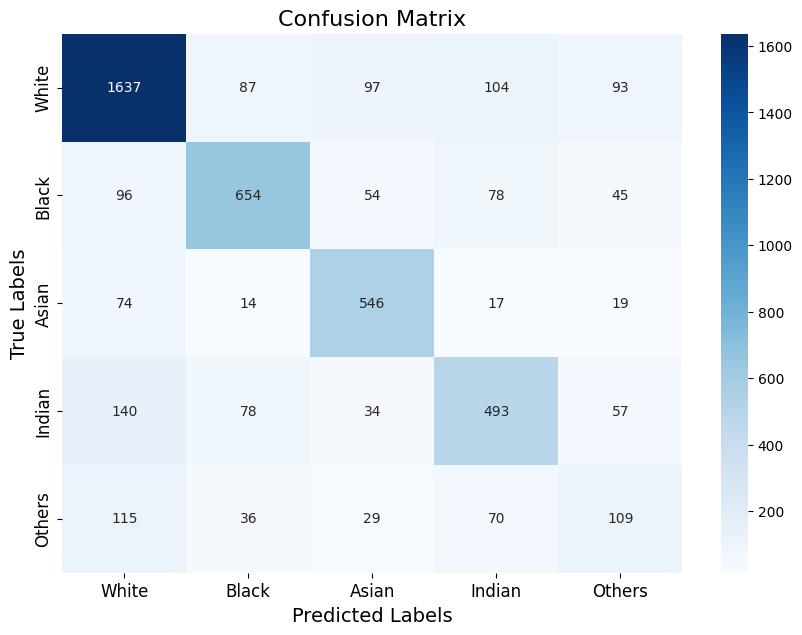


Classification Report:
              precision    recall  f1-score   support

       White       0.79      0.81      0.80      2018
       Black       0.75      0.71      0.73       927
       Asian       0.72      0.81      0.76       670
      Indian       0.65      0.61      0.63       802
      Others       0.34      0.30      0.32       359

    accuracy                           0.72      4776
   macro avg       0.65      0.65      0.65      4776
weighted avg       0.72      0.72      0.72      4776



In [8]:

all_labels = []  # Per memorizzare le etichette reali
all_preds = []   # Per memorizzare le previsioni del modello

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = eyes_net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calcola le metriche
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Aggiungi titoli e etichette agli assi
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostra la heatmap
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

**NOSE TRAINING VALIDATION AND TEST**

In [9]:
# Inizializzare il dataset
full_train_dataset = EthnicityDataset(root_dir="Dataset/nose/train", transform=transform_nose)
test_dataset = EthnicityDataset(root_dir="Dataset/nose/test", transform=transform_nose)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Parametri di Early Stopping
patience = 4  # Numero massimo di epoche senza miglioramenti


# K-fold Cross-Validation
k = 5  # Numero di fold per la K-Fold Cross Validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Array per salvare i risultati di ogni fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []

num_epochs = 10
batch_size = 32

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_train_dataset)))):
    print(f"Fold {fold + 1}/{k}")

    # Creare i subset per training e validation
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Creare i dataloader per il fold corrente
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Reinizializzare il modello e l'ottimizzatore per ogni fold
    nose_net = nose_net.to(device)  # Assicurarsi che il modello sia su GPU/CPU corretta
    nose_optimizer = torch.optim.Adam(nose_net.parameters(), lr=0.001, weight_decay=0.0001)

    # Criterion
    criterion = nn.CrossEntropyLoss()

    best_model_state = None  # Per salvare lo stato del modello
    best_val_loss = float("inf")  # Migliore loss iniziale
    no_improvement = 0  # Contatore per epoche senza miglioramenti

    # Metriche per ogni fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training per ogni fold
    for epoch in range(num_epochs):
        # Training Phase
        nose_net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Training Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            nose_optimizer.zero_grad()

            # Forward pass
            outputs = nose_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            nose_optimizer.step()

            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        nose_net.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = nose_net(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early Stopping: verifica miglioramento della loss di validazione
        if avg_val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
            best_val_loss = avg_val_loss
            best_model_state = nose_net.state_dict()  # Salva il miglior modello
            no_improvement = 0  # Resetta il contatore
        else:
            no_improvement += 1
            print(f"No improvement for {no_improvement} epochs.")

        # Controlla se interrompere l'allenamento per Early Stopping
        if no_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

    # Carica il miglior modello salvato per questo fold
    nose_net.load_state_dict(best_model_state)

    # Salvare i risultati del fold corrente
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

# Calcolare le metriche medie su tutti i fold
mean_train_loss = np.mean([np.mean(fold) for fold in fold_train_losses])
mean_val_loss = np.mean([np.mean(fold) for fold in fold_val_losses])
mean_train_accuracy = np.mean([np.mean(fold) for fold in fold_train_accuracies])
mean_val_accuracy = np.mean([np.mean(fold) for fold in fold_val_accuracies])

print(f"Average Training Loss: {mean_train_loss:.4f}")
print(f"Average Validation Loss: {mean_val_loss:.4f}")
print(f"Average Training Accuracy: {mean_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {mean_val_accuracy:.4f}")

Fold 1/5


Training Fold 1, Epoch 1: 100%|██████████| 457/457 [00:32<00:00, 14.21batch/s]


Fold 1, Epoch 1, Train Loss: 1.3477, Train Accuracy: 0.4806


Validating Fold 1, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 24.09batch/s]


Fold 1, Epoch 1, Val Loss: 1.2792, Val Accuracy: 0.5119
Validation loss improved from inf to 1.2792. Saving model...


Training Fold 1, Epoch 2: 100%|██████████| 457/457 [00:32<00:00, 14.20batch/s]


Fold 1, Epoch 2, Train Loss: 1.1826, Train Accuracy: 0.5420


Validating Fold 1, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 24.89batch/s]


Fold 1, Epoch 2, Val Loss: 1.1072, Val Accuracy: 0.5760
Validation loss improved from 1.2792 to 1.1072. Saving model...


Training Fold 1, Epoch 3: 100%|██████████| 457/457 [00:32<00:00, 14.04batch/s]


Fold 1, Epoch 3, Train Loss: 1.1024, Train Accuracy: 0.5872


Validating Fold 1, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 24.49batch/s]


Fold 1, Epoch 3, Val Loss: 1.0365, Val Accuracy: 0.6209
Validation loss improved from 1.1072 to 1.0365. Saving model...


Training Fold 1, Epoch 4: 100%|██████████| 457/457 [00:32<00:00, 14.10batch/s]


Fold 1, Epoch 4, Train Loss: 1.0397, Train Accuracy: 0.6147


Validating Fold 1, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 24.68batch/s]


Fold 1, Epoch 4, Val Loss: 1.0152, Val Accuracy: 0.6289
Validation loss improved from 1.0365 to 1.0152. Saving model...


Training Fold 1, Epoch 5: 100%|██████████| 457/457 [00:32<00:00, 14.18batch/s]


Fold 1, Epoch 5, Train Loss: 0.9999, Train Accuracy: 0.6262


Validating Fold 1, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 23.88batch/s]


Fold 1, Epoch 5, Val Loss: 1.0132, Val Accuracy: 0.6280
Validation loss improved from 1.0152 to 1.0132. Saving model...


Training Fold 1, Epoch 6: 100%|██████████| 457/457 [00:31<00:00, 14.33batch/s]


Fold 1, Epoch 6, Train Loss: 0.9659, Train Accuracy: 0.6447


Validating Fold 1, Epoch 6: 100%|██████████| 115/115 [00:05<00:00, 22.76batch/s]


Fold 1, Epoch 6, Val Loss: 0.9393, Val Accuracy: 0.6579
Validation loss improved from 1.0132 to 0.9393. Saving model...


Training Fold 1, Epoch 7: 100%|██████████| 457/457 [00:31<00:00, 14.34batch/s]


Fold 1, Epoch 7, Train Loss: 0.9333, Train Accuracy: 0.6560


Validating Fold 1, Epoch 7: 100%|██████████| 115/115 [00:05<00:00, 22.24batch/s]


Fold 1, Epoch 7, Val Loss: 0.9142, Val Accuracy: 0.6680
Validation loss improved from 0.9393 to 0.9142. Saving model...


Training Fold 1, Epoch 8: 100%|██████████| 457/457 [00:31<00:00, 14.35batch/s]


Fold 1, Epoch 8, Train Loss: 0.9091, Train Accuracy: 0.6645


Validating Fold 1, Epoch 8: 100%|██████████| 115/115 [00:05<00:00, 22.26batch/s]


Fold 1, Epoch 8, Val Loss: 0.9262, Val Accuracy: 0.6604
No improvement for 1 epochs.


Training Fold 1, Epoch 9: 100%|██████████| 457/457 [00:31<00:00, 14.31batch/s]


Fold 1, Epoch 9, Train Loss: 0.8813, Train Accuracy: 0.6748


Validating Fold 1, Epoch 9: 100%|██████████| 115/115 [00:04<00:00, 24.61batch/s]


Fold 1, Epoch 9, Val Loss: 0.9041, Val Accuracy: 0.6853
Validation loss improved from 0.9142 to 0.9041. Saving model...


Training Fold 1, Epoch 10: 100%|██████████| 457/457 [00:32<00:00, 14.20batch/s]


Fold 1, Epoch 10, Train Loss: 0.8538, Train Accuracy: 0.6901


Validating Fold 1, Epoch 10: 100%|██████████| 115/115 [00:04<00:00, 24.78batch/s]


Fold 1, Epoch 10, Val Loss: 0.9201, Val Accuracy: 0.6730
No improvement for 1 epochs.
Fold 2/5


Training Fold 2, Epoch 1: 100%|██████████| 457/457 [00:32<00:00, 14.19batch/s]


Fold 2, Epoch 1, Train Loss: 0.8601, Train Accuracy: 0.6869


Validating Fold 2, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 24.69batch/s]


Fold 2, Epoch 1, Val Loss: 0.7785, Val Accuracy: 0.7179
Validation loss improved from inf to 0.7785. Saving model...


Training Fold 2, Epoch 2: 100%|██████████| 457/457 [00:32<00:00, 14.21batch/s]


Fold 2, Epoch 2, Train Loss: 0.8212, Train Accuracy: 0.6996


Validating Fold 2, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 24.46batch/s]


Fold 2, Epoch 2, Val Loss: 0.7968, Val Accuracy: 0.7097
No improvement for 1 epochs.


Training Fold 2, Epoch 3: 100%|██████████| 457/457 [00:32<00:00, 14.27batch/s]


Fold 2, Epoch 3, Train Loss: 0.7897, Train Accuracy: 0.7106


Validating Fold 2, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 23.85batch/s]


Fold 2, Epoch 3, Val Loss: 0.8488, Val Accuracy: 0.6987
No improvement for 2 epochs.


Training Fold 2, Epoch 4: 100%|██████████| 457/457 [00:31<00:00, 14.35batch/s]


Fold 2, Epoch 4, Train Loss: 0.7448, Train Accuracy: 0.7288


Validating Fold 2, Epoch 4: 100%|██████████| 115/115 [00:05<00:00, 22.02batch/s]


Fold 2, Epoch 4, Val Loss: 0.8348, Val Accuracy: 0.7053
No improvement for 3 epochs.


Training Fold 2, Epoch 5: 100%|██████████| 457/457 [00:31<00:00, 14.35batch/s]


Fold 2, Epoch 5, Train Loss: 0.7119, Train Accuracy: 0.7389


Validating Fold 2, Epoch 5: 100%|██████████| 115/115 [00:05<00:00, 21.93batch/s]


Fold 2, Epoch 5, Val Loss: 0.8347, Val Accuracy: 0.6995
No improvement for 4 epochs.
Early stopping triggered at epoch 5.
Fold 3/5


Training Fold 3, Epoch 1: 100%|██████████| 457/457 [00:31<00:00, 14.39batch/s]


Fold 3, Epoch 1, Train Loss: 0.7445, Train Accuracy: 0.7301


Validating Fold 3, Epoch 1: 100%|██████████| 115/115 [00:05<00:00, 22.54batch/s]


Fold 3, Epoch 1, Val Loss: 0.6624, Val Accuracy: 0.7529
Validation loss improved from inf to 0.6624. Saving model...


Training Fold 3, Epoch 2: 100%|██████████| 457/457 [00:32<00:00, 14.27batch/s]


Fold 3, Epoch 2, Train Loss: 0.6799, Train Accuracy: 0.7499


Validating Fold 3, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 24.47batch/s]


Fold 3, Epoch 2, Val Loss: 0.6364, Val Accuracy: 0.7798
Validation loss improved from 0.6624 to 0.6364. Saving model...


Training Fold 3, Epoch 3: 100%|██████████| 457/457 [00:32<00:00, 14.21batch/s]


Fold 3, Epoch 3, Train Loss: 0.6466, Train Accuracy: 0.7639


Validating Fold 3, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 24.83batch/s]


Fold 3, Epoch 3, Val Loss: 0.6665, Val Accuracy: 0.7655
No improvement for 1 epochs.


Training Fold 3, Epoch 4: 100%|██████████| 457/457 [00:32<00:00, 14.22batch/s]


Fold 3, Epoch 4, Train Loss: 0.5929, Train Accuracy: 0.7842


Validating Fold 3, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 24.94batch/s]


Fold 3, Epoch 4, Val Loss: 0.7087, Val Accuracy: 0.7436
No improvement for 2 epochs.


Training Fold 3, Epoch 5: 100%|██████████| 457/457 [00:32<00:00, 14.21batch/s]


Fold 3, Epoch 5, Train Loss: 0.5563, Train Accuracy: 0.7965


Validating Fold 3, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 25.12batch/s]


Fold 3, Epoch 5, Val Loss: 0.7200, Val Accuracy: 0.7387
No improvement for 3 epochs.


Training Fold 3, Epoch 6: 100%|██████████| 457/457 [00:32<00:00, 14.25batch/s]


Fold 3, Epoch 6, Train Loss: 0.4978, Train Accuracy: 0.8191


Validating Fold 3, Epoch 6: 100%|██████████| 115/115 [00:04<00:00, 24.22batch/s]


Fold 3, Epoch 6, Val Loss: 0.7606, Val Accuracy: 0.7319
No improvement for 4 epochs.
Early stopping triggered at epoch 6.
Fold 4/5


Training Fold 4, Epoch 1: 100%|██████████| 457/457 [00:31<00:00, 14.31batch/s]


Fold 4, Epoch 1, Train Loss: 0.5965, Train Accuracy: 0.7891


Validating Fold 4, Epoch 1: 100%|██████████| 115/115 [00:05<00:00, 21.91batch/s]


Fold 4, Epoch 1, Val Loss: 0.4028, Val Accuracy: 0.8554
Validation loss improved from inf to 0.4028. Saving model...


Training Fold 4, Epoch 2: 100%|██████████| 457/457 [00:31<00:00, 14.35batch/s]


Fold 4, Epoch 2, Train Loss: 0.5048, Train Accuracy: 0.8177


Validating Fold 4, Epoch 2: 100%|██████████| 115/115 [00:05<00:00, 22.02batch/s]


Fold 4, Epoch 2, Val Loss: 0.4234, Val Accuracy: 0.8485
No improvement for 1 epochs.


Training Fold 4, Epoch 3: 100%|██████████| 457/457 [00:31<00:00, 14.30batch/s]


Fold 4, Epoch 3, Train Loss: 0.4543, Train Accuracy: 0.8350


Validating Fold 4, Epoch 3: 100%|██████████| 115/115 [00:05<00:00, 21.88batch/s]


Fold 4, Epoch 3, Val Loss: 0.4842, Val Accuracy: 0.8179
No improvement for 2 epochs.


Training Fold 4, Epoch 4: 100%|██████████| 457/457 [00:31<00:00, 14.36batch/s]


Fold 4, Epoch 4, Train Loss: 0.4124, Train Accuracy: 0.8495


Validating Fold 4, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 23.99batch/s]


Fold 4, Epoch 4, Val Loss: 0.5249, Val Accuracy: 0.8135
No improvement for 3 epochs.


Training Fold 4, Epoch 5: 100%|██████████| 457/457 [00:32<00:00, 14.24batch/s]


Fold 4, Epoch 5, Train Loss: 0.3854, Train Accuracy: 0.8614


Validating Fold 4, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 24.99batch/s]


Fold 4, Epoch 5, Val Loss: 0.5755, Val Accuracy: 0.7921
No improvement for 4 epochs.
Early stopping triggered at epoch 5.
Fold 5/5


Training Fold 5, Epoch 1: 100%|██████████| 457/457 [00:32<00:00, 14.23batch/s]


Fold 5, Epoch 1, Train Loss: 0.4653, Train Accuracy: 0.8301


Validating Fold 5, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 24.71batch/s]


Fold 5, Epoch 1, Val Loss: 0.2355, Val Accuracy: 0.9255
Validation loss improved from inf to 0.2355. Saving model...


Training Fold 5, Epoch 2: 100%|██████████| 457/457 [00:32<00:00, 14.20batch/s]


Fold 5, Epoch 2, Train Loss: 0.3701, Train Accuracy: 0.8653


Validating Fold 5, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 24.88batch/s]


Fold 5, Epoch 2, Val Loss: 0.3140, Val Accuracy: 0.8940
No improvement for 1 epochs.


Training Fold 5, Epoch 3: 100%|██████████| 457/457 [00:31<00:00, 14.29batch/s]


Fold 5, Epoch 3, Train Loss: 0.3340, Train Accuracy: 0.8782


Validating Fold 5, Epoch 3: 100%|██████████| 115/115 [00:05<00:00, 22.96batch/s]


Fold 5, Epoch 3, Val Loss: 0.3633, Val Accuracy: 0.8685
No improvement for 2 epochs.


Training Fold 5, Epoch 4: 100%|██████████| 457/457 [00:31<00:00, 14.44batch/s]


Fold 5, Epoch 4, Train Loss: 0.2968, Train Accuracy: 0.8911


Validating Fold 5, Epoch 4: 100%|██████████| 115/115 [00:05<00:00, 22.21batch/s]


Fold 5, Epoch 4, Val Loss: 0.4082, Val Accuracy: 0.8584
No improvement for 3 epochs.


Training Fold 5, Epoch 5: 100%|██████████| 457/457 [00:31<00:00, 14.42batch/s]


Fold 5, Epoch 5, Train Loss: 0.2978, Train Accuracy: 0.8922


Validating Fold 5, Epoch 5: 100%|██████████| 115/115 [00:05<00:00, 22.30batch/s]

Fold 5, Epoch 5, Val Loss: 0.4239, Val Accuracy: 0.8447
No improvement for 4 epochs.
Early stopping triggered at epoch 5.
Average Training Loss: 0.6500
Average Validation Loss: 0.6696
Average Training Accuracy: 0.7614
Average Validation Accuracy: 0.7586


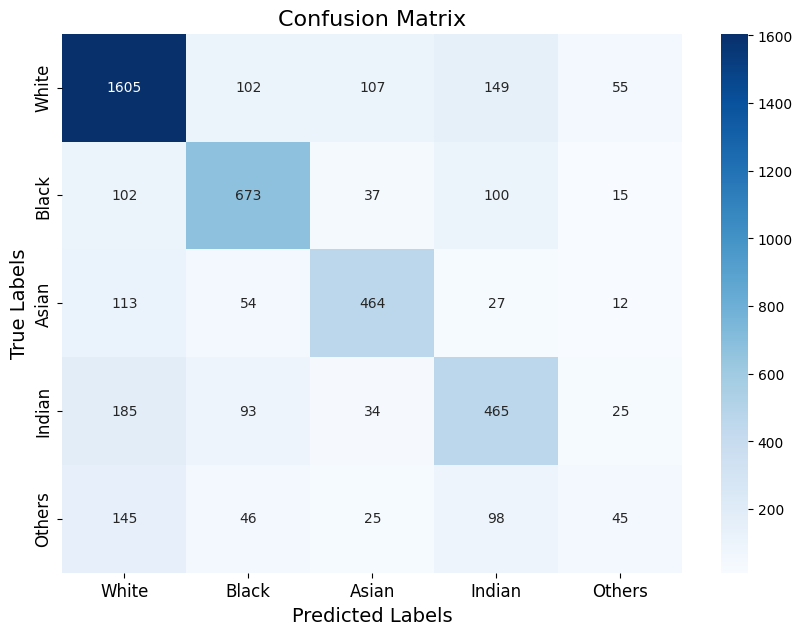


Classification Report:
              precision    recall  f1-score   support

       White       0.75      0.80      0.77      2018
       Black       0.70      0.73      0.71       927
       Asian       0.70      0.69      0.69       670
      Indian       0.55      0.58      0.57       802
      Others       0.30      0.13      0.18       359

    accuracy                           0.68      4776
   macro avg       0.60      0.58      0.58      4776
weighted avg       0.66      0.68      0.67      4776



In [10]:
all_labels = []
all_preds = []

with torch.no_grad():  # Disabilita il calcolo dei gradienti
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)


        # Forward pass
        outputs = nose_net(images)

        # Calcola le predizioni
        _, predicted = torch.max(outputs.data, 1)

        # Salva le etichette e le predizioni
        all_labels.extend(labels.cpu().numpy())        # Porta le etichette sulla CPU prima di salvarle
        all_preds.extend(predicted.cpu().numpy())


# Calcola le metriche
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Aggiungi titoli e etichette agli assi
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostra la heatmap
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

**MOUTH TRAINING VALIDATION AND TEST**

In [11]:
# Inizializzare il dataset
full_train_dataset = EthnicityDataset(root_dir="Dataset/mouth/train", transform=transform_mouth)
test_dataset = EthnicityDataset(root_dir="Dataset/mouth/test", transform=transform_mouth)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Parametri di Early Stopping
patience = 4  # Numero massimo di epoche senza miglioramenti

# K-fold Cross-Validation
k = 5  # Scegliamo K = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Array per salvare i risultati di ogni fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []

num_epochs = 10
batch_size = 32

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_train_dataset)))):
    print(f"Fold {fold + 1}/{k}")

    # Creare i subset per training e validation
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Creare i dataloader per il fold corrente
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Reinizializzare il modello e l'ottimizzatore per ogni fold
    mouth_net = mouth_net.to(device)  # Assicurarsi che il modello sia su GPU/CPU corretta
    mouth_optimizer = torch.optim.Adam(mouth_net.parameters(), lr=0.001, weight_decay=0.001)

    # Criterion
    criterion = nn.CrossEntropyLoss()

    best_model_state = None  # Per salvare lo stato del modello
    best_val_loss = float("inf")  # Migliore loss iniziale
    no_improvement = 0  # Contatore per epoche senza miglioramenti

    # Metriche per ogni fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training per ogni fold
    for epoch in range(num_epochs):
        # Training Phase
        mouth_net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Training Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            mouth_optimizer.zero_grad()

            # Forward pass
            outputs = mouth_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            mouth_optimizer.step()

            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        mouth_net.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = mouth_net(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early Stopping: verifica miglioramento della loss di validazione
        if avg_val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
            best_val_loss = avg_val_loss
            best_model_state = mouth_net.state_dict()  # Salva il miglior modello
            no_improvement = 0  # Resetta il contatore
        else:
            no_improvement += 1
            print(f"No improvement for {no_improvement} epochs.")

        # Controlla se interrompere l'allenamento per Early Stopping
        if no_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

    # Carica il miglior modello salvato per questo fold
    mouth_net.load_state_dict(best_model_state)

    # Salvare i risultati del fold corrente
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

# Calcolare le metriche medie su tutti i fold
mean_train_loss = np.mean([np.mean(fold) for fold in fold_train_losses])
mean_val_loss = np.mean([np.mean(fold) for fold in fold_val_losses])
mean_train_accuracy = np.mean([np.mean(fold) for fold in fold_train_accuracies])
mean_val_accuracy = np.mean([np.mean(fold) for fold in fold_val_accuracies])

print(f"Average Training Loss: {mean_train_loss:.4f}")
print(f"Average Validation Loss: {mean_val_loss:.4f}")
print(f"Average Training Accuracy: {mean_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {mean_val_accuracy:.4f}")

Fold 1/5


Training Fold 1, Epoch 1: 100%|██████████| 457/457 [00:30<00:00, 14.80batch/s]


Fold 1, Epoch 1, Train Loss: 1.2384, Train Accuracy: 0.5314


Validating Fold 1, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 25.24batch/s]


Fold 1, Epoch 1, Val Loss: 1.1697, Val Accuracy: 0.5557
Validation loss improved from inf to 1.1697. Saving model...


Training Fold 1, Epoch 2: 100%|██████████| 457/457 [00:30<00:00, 15.05batch/s]


Fold 1, Epoch 2, Train Loss: 1.1337, Train Accuracy: 0.5674


Validating Fold 1, Epoch 2: 100%|██████████| 115/115 [00:05<00:00, 23.00batch/s]


Fold 1, Epoch 2, Val Loss: 1.1575, Val Accuracy: 0.5733
Validation loss improved from 1.1697 to 1.1575. Saving model...


Training Fold 1, Epoch 3: 100%|██████████| 457/457 [00:30<00:00, 15.06batch/s]


Fold 1, Epoch 3, Train Loss: 1.1081, Train Accuracy: 0.5824


Validating Fold 1, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 25.87batch/s]


Fold 1, Epoch 3, Val Loss: 1.0900, Val Accuracy: 0.6012
Validation loss improved from 1.1575 to 1.0900. Saving model...


Training Fold 1, Epoch 4: 100%|██████████| 457/457 [00:30<00:00, 14.91batch/s]


Fold 1, Epoch 4, Train Loss: 1.0857, Train Accuracy: 0.5879


Validating Fold 1, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 25.65batch/s]


Fold 1, Epoch 4, Val Loss: 1.0608, Val Accuracy: 0.6061
Validation loss improved from 1.0900 to 1.0608. Saving model...


Training Fold 1, Epoch 5: 100%|██████████| 457/457 [00:30<00:00, 14.97batch/s]


Fold 1, Epoch 5, Train Loss: 1.0641, Train Accuracy: 0.5968


Validating Fold 1, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 24.68batch/s]


Fold 1, Epoch 5, Val Loss: 1.1027, Val Accuracy: 0.5837
No improvement for 1 epochs.


Training Fold 1, Epoch 6: 100%|██████████| 457/457 [00:30<00:00, 15.09batch/s]


Fold 1, Epoch 6, Train Loss: 1.0519, Train Accuracy: 0.6035


Validating Fold 1, Epoch 6: 100%|██████████| 115/115 [00:04<00:00, 23.08batch/s]


Fold 1, Epoch 6, Val Loss: 1.0438, Val Accuracy: 0.6053
Validation loss improved from 1.0608 to 1.0438. Saving model...


Training Fold 1, Epoch 7: 100%|██████████| 457/457 [00:30<00:00, 15.05batch/s]


Fold 1, Epoch 7, Train Loss: 1.0425, Train Accuracy: 0.6141


Validating Fold 1, Epoch 7: 100%|██████████| 115/115 [00:04<00:00, 26.15batch/s]


Fold 1, Epoch 7, Val Loss: 1.1003, Val Accuracy: 0.5735
No improvement for 1 epochs.


Training Fold 1, Epoch 8: 100%|██████████| 457/457 [00:30<00:00, 14.87batch/s]


Fold 1, Epoch 8, Train Loss: 1.0283, Train Accuracy: 0.6207


Validating Fold 1, Epoch 8: 100%|██████████| 115/115 [00:04<00:00, 25.83batch/s]


Fold 1, Epoch 8, Val Loss: 1.0270, Val Accuracy: 0.6042
Validation loss improved from 1.0438 to 1.0270. Saving model...


Training Fold 1, Epoch 9: 100%|██████████| 457/457 [00:30<00:00, 15.04batch/s]


Fold 1, Epoch 9, Train Loss: 1.0174, Train Accuracy: 0.6222


Validating Fold 1, Epoch 9: 100%|██████████| 115/115 [00:04<00:00, 23.06batch/s]


Fold 1, Epoch 9, Val Loss: 0.9943, Val Accuracy: 0.6278
Validation loss improved from 1.0270 to 0.9943. Saving model...


Training Fold 1, Epoch 10: 100%|██████████| 457/457 [00:30<00:00, 15.02batch/s]


Fold 1, Epoch 10, Train Loss: 1.0056, Train Accuracy: 0.6260


Validating Fold 1, Epoch 10: 100%|██████████| 115/115 [00:04<00:00, 24.20batch/s]


Fold 1, Epoch 10, Val Loss: 0.9821, Val Accuracy: 0.6316
Validation loss improved from 0.9943 to 0.9821. Saving model...
Fold 2/5


Training Fold 2, Epoch 1: 100%|██████████| 457/457 [00:30<00:00, 14.95batch/s]


Fold 2, Epoch 1, Train Loss: 0.9898, Train Accuracy: 0.6319


Validating Fold 2, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 26.44batch/s]


Fold 2, Epoch 1, Val Loss: 0.9730, Val Accuracy: 0.6313
Validation loss improved from inf to 0.9730. Saving model...


Training Fold 2, Epoch 2: 100%|██████████| 457/457 [00:30<00:00, 14.90batch/s]


Fold 2, Epoch 2, Train Loss: 0.9755, Train Accuracy: 0.6374


Validating Fold 2, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 25.96batch/s]


Fold 2, Epoch 2, Val Loss: 0.9461, Val Accuracy: 0.6631
Validation loss improved from 0.9730 to 0.9461. Saving model...


Training Fold 2, Epoch 3: 100%|██████████| 457/457 [00:30<00:00, 15.04batch/s]


Fold 2, Epoch 3, Train Loss: 0.9558, Train Accuracy: 0.6510


Validating Fold 2, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 23.10batch/s]


Fold 2, Epoch 3, Val Loss: 0.9799, Val Accuracy: 0.6365
No improvement for 1 epochs.


Training Fold 2, Epoch 4: 100%|██████████| 457/457 [00:30<00:00, 15.08batch/s]


Fold 2, Epoch 4, Train Loss: 0.9383, Train Accuracy: 0.6556


Validating Fold 2, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 25.00batch/s]


Fold 2, Epoch 4, Val Loss: 0.9644, Val Accuracy: 0.6535
No improvement for 2 epochs.


Training Fold 2, Epoch 5: 100%|██████████| 457/457 [00:30<00:00, 14.93batch/s]


Fold 2, Epoch 5, Train Loss: 0.9283, Train Accuracy: 0.6504


Validating Fold 2, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 25.83batch/s]


Fold 2, Epoch 5, Val Loss: 0.9529, Val Accuracy: 0.6541
No improvement for 3 epochs.


Training Fold 2, Epoch 6: 100%|██████████| 457/457 [00:30<00:00, 14.82batch/s]


Fold 2, Epoch 6, Train Loss: 0.9128, Train Accuracy: 0.6613


Validating Fold 2, Epoch 6: 100%|██████████| 115/115 [00:04<00:00, 26.09batch/s]


Fold 2, Epoch 6, Val Loss: 0.9766, Val Accuracy: 0.6406
No improvement for 4 epochs.
Early stopping triggered at epoch 6.
Fold 3/5


Training Fold 3, Epoch 1: 100%|██████████| 457/457 [00:30<00:00, 15.06batch/s]


Fold 3, Epoch 1, Train Loss: 0.9180, Train Accuracy: 0.6637


Validating Fold 3, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 23.07batch/s]


Fold 3, Epoch 1, Val Loss: 0.8587, Val Accuracy: 0.6883
Validation loss improved from inf to 0.8587. Saving model...


Training Fold 3, Epoch 2: 100%|██████████| 457/457 [00:30<00:00, 15.03batch/s]


Fold 3, Epoch 2, Train Loss: 0.8940, Train Accuracy: 0.6715


Validating Fold 3, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 25.74batch/s]


Fold 3, Epoch 2, Val Loss: 0.8782, Val Accuracy: 0.6784
No improvement for 1 epochs.


Training Fold 3, Epoch 3: 100%|██████████| 457/457 [00:30<00:00, 14.84batch/s]


Fold 3, Epoch 3, Train Loss: 0.8862, Train Accuracy: 0.6790


Validating Fold 3, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 26.41batch/s]


Fold 3, Epoch 3, Val Loss: 0.8644, Val Accuracy: 0.6842
No improvement for 2 epochs.


Training Fold 3, Epoch 4: 100%|██████████| 457/457 [00:30<00:00, 14.90batch/s]


Fold 3, Epoch 4, Train Loss: 0.8678, Train Accuracy: 0.6854


Validating Fold 3, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 24.03batch/s]


Fold 3, Epoch 4, Val Loss: 0.8806, Val Accuracy: 0.6738
No improvement for 3 epochs.


Training Fold 3, Epoch 5: 100%|██████████| 457/457 [00:30<00:00, 15.05batch/s]


Fold 3, Epoch 5, Train Loss: 0.8533, Train Accuracy: 0.6892


Validating Fold 3, Epoch 5: 100%|██████████| 115/115 [00:05<00:00, 22.41batch/s]


Fold 3, Epoch 5, Val Loss: 0.9218, Val Accuracy: 0.6708
No improvement for 4 epochs.
Early stopping triggered at epoch 5.
Fold 4/5


Training Fold 4, Epoch 1: 100%|██████████| 457/457 [00:30<00:00, 14.99batch/s]


Fold 4, Epoch 1, Train Loss: 0.8725, Train Accuracy: 0.6834


Validating Fold 4, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 26.22batch/s]


Fold 4, Epoch 1, Val Loss: 0.7765, Val Accuracy: 0.7099
Validation loss improved from inf to 0.7765. Saving model...


Training Fold 4, Epoch 2: 100%|██████████| 457/457 [00:30<00:00, 14.80batch/s]


Fold 4, Epoch 2, Train Loss: 0.8440, Train Accuracy: 0.6934


Validating Fold 4, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 26.35batch/s]


Fold 4, Epoch 2, Val Loss: 0.7991, Val Accuracy: 0.7080
No improvement for 1 epochs.


Training Fold 4, Epoch 3: 100%|██████████| 457/457 [00:30<00:00, 14.99batch/s]


Fold 4, Epoch 3, Train Loss: 0.8209, Train Accuracy: 0.6981


Validating Fold 4, Epoch 3: 100%|██████████| 115/115 [00:05<00:00, 22.95batch/s]


Fold 4, Epoch 3, Val Loss: 0.7963, Val Accuracy: 0.7075
No improvement for 2 epochs.


Training Fold 4, Epoch 4: 100%|██████████| 457/457 [00:30<00:00, 14.99batch/s]


Fold 4, Epoch 4, Train Loss: 0.8137, Train Accuracy: 0.7059


Validating Fold 4, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 24.83batch/s]


Fold 4, Epoch 4, Val Loss: 0.8103, Val Accuracy: 0.7069
No improvement for 3 epochs.


Training Fold 4, Epoch 5: 100%|██████████| 457/457 [00:30<00:00, 14.95batch/s]


Fold 4, Epoch 5, Train Loss: 0.7983, Train Accuracy: 0.7070


Validating Fold 4, Epoch 5: 100%|██████████| 115/115 [00:04<00:00, 26.21batch/s]


Fold 4, Epoch 5, Val Loss: 0.8183, Val Accuracy: 0.6982
No improvement for 4 epochs.
Early stopping triggered at epoch 5.
Fold 5/5


Training Fold 5, Epoch 1: 100%|██████████| 457/457 [00:30<00:00, 14.89batch/s]


Fold 5, Epoch 1, Train Loss: 0.8201, Train Accuracy: 0.7019


Validating Fold 5, Epoch 1: 100%|██████████| 115/115 [00:04<00:00, 24.59batch/s]


Fold 5, Epoch 1, Val Loss: 0.7356, Val Accuracy: 0.7417
Validation loss improved from inf to 0.7356. Saving model...


Training Fold 5, Epoch 2: 100%|██████████| 457/457 [00:30<00:00, 15.08batch/s]


Fold 5, Epoch 2, Train Loss: 0.7749, Train Accuracy: 0.7170


Validating Fold 5, Epoch 2: 100%|██████████| 115/115 [00:04<00:00, 23.18batch/s]


Fold 5, Epoch 2, Val Loss: 0.7555, Val Accuracy: 0.7239
No improvement for 1 epochs.


Training Fold 5, Epoch 3: 100%|██████████| 457/457 [00:30<00:00, 15.11batch/s]


Fold 5, Epoch 3, Train Loss: 0.7625, Train Accuracy: 0.7220


Validating Fold 5, Epoch 3: 100%|██████████| 115/115 [00:04<00:00, 26.25batch/s]


Fold 5, Epoch 3, Val Loss: 0.8016, Val Accuracy: 0.7017
No improvement for 2 epochs.


Training Fold 5, Epoch 4: 100%|██████████| 457/457 [00:30<00:00, 14.89batch/s]


Fold 5, Epoch 4, Train Loss: 0.7357, Train Accuracy: 0.7338


Validating Fold 5, Epoch 4: 100%|██████████| 115/115 [00:04<00:00, 25.93batch/s]


Fold 5, Epoch 4, Val Loss: 0.7898, Val Accuracy: 0.7108
No improvement for 3 epochs.


Training Fold 5, Epoch 5: 100%|██████████| 457/457 [00:30<00:00, 15.11batch/s]


Fold 5, Epoch 5, Train Loss: 0.7253, Train Accuracy: 0.7344


Validating Fold 5, Epoch 5: 100%|██████████| 115/115 [00:05<00:00, 22.88batch/s]

Fold 5, Epoch 5, Val Loss: 0.8503, Val Accuracy: 0.6861
No improvement for 4 epochs.
Early stopping triggered at epoch 5.
Average Training Loss: 0.9010
Average Validation Loss: 0.9011
Average Training Accuracy: 0.6681
Average Validation Accuracy: 0.6682


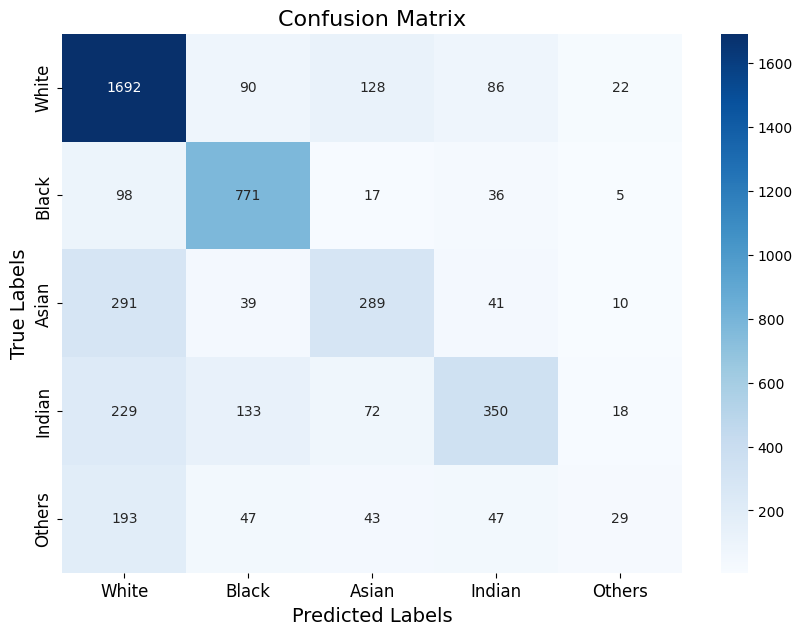


Classification Report:
              precision    recall  f1-score   support

       White       0.68      0.84      0.75      2018
       Black       0.71      0.83      0.77       927
       Asian       0.53      0.43      0.47       670
      Indian       0.62      0.44      0.51       802
      Others       0.35      0.08      0.13       359

    accuracy                           0.66      4776
   macro avg       0.58      0.52      0.53      4776
weighted avg       0.63      0.66      0.63      4776



In [12]:
all_labels = []  # Per memorizzare le etichette reali
all_preds = []   # Per memorizzare le previsioni del modello

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = mouth_net(images)

        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())


# Calcola le metriche
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Aggiungi titoli e etichette agli assi
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostra la heatmap
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))